# Triangulation
Useful links:
- [ ] https://www.youtube.com/watch?v=UZlRhEUWSas
- [ ] https://en.wikipedia.org/wiki/Triangulation_(computer_vision)
- [ ] https://gist.github.com/cr333/0d0e6c256f93c0ed7bd2
- [ ] https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/autonomous-vision/lectures/computer-vision/
- [ ] https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html
- [ ] https://www.changjiangcai.com/files/text-books/Richard_Hartley_Andrew_Zisserman-Multiple_View_Geometry_in_Computer_Vision-EN.pdf
- [ ] https://medium.com/@insight-in-plain-sight/estimating-the-homography-matrix-with-the-direct-linear-transform-dlt-ec6bbb82ee2b
- [ ] https://glowingpython.blogspot.com/2011/06/svd-decomposition-with-numpy.html

In [101]:
pip install opencv-python numpy scipy matplotlib pandas tabulate

Note: you may need to restart the kernel to use updated packages.


In [102]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from src.hz_triangulation import HZTriangulation
from src.calibrator import Calibrator
# from src.calibrator import additional_points
import importlib  # importlib is a module from the standard library
import src.utils as utils
import src.hz_triangulation

np.set_printoptions(precision=5, suppress=True)
importlib.reload(src.hz_triangulation)

imgpoints_reorder = [
    True,
    True,
    False,
    False,
    True,
    True,
    False,
    False,
    False,
    True
]

additional_points = [[[1023, 1003], [508, 1504]],
                     [[1180, 1287], [932, 1735]],
                     [],
                     [],
                     [],
                     [],
                     [],
                     [[2440, 1772], [3253, 1779], [525, 594], [2438, 142],
                         [2019, 142], [556, 454], [1039, 1804]],
                     [[1309, 1836], [1766, 2248], [1198, 466], [2925, 639],
                         [3440, 395], [1914, 266], [707, 1331]],
                     [],
                     ]

In [103]:
frame_size = (3648, 2736)

calibrator = Calibrator('assets/calibration_new/', 'img-*.jpg',
                        frameSize=frame_size, chessboardSize=(7, 5), chessboard_square_mm=29.15)
calibrator.calibrate()

True
True
True
True
True
True
True
True
True
True

Camera calibrated:  0.4178394466041533
Camera Matrix:  [[2790.294373778    0.          1827.29216617 ]
 [   0.          2794.318007802 1402.015521139]
 [   0.             0.             1.         ]]
Distortion Parameters:  [[ 0.27683505  -2.987342069  0.000200696  0.000459854  6.71839633 ]]
Rotation Vectors:  (array([[-0.741706647],
       [-0.008120225],
       [-0.182648646]]), array([[-0.502829282],
       [ 0.020669438],
       [-0.270155395]]), array([[-0.761454366],
       [ 0.475764108],
       [ 1.298924242]]), array([[-0.481109249],
       [ 0.147693592],
       [ 0.626032156]]), array([[-0.205764957],
       [ 0.42302761 ],
       [ 1.380929914]]), array([[-0.38922491 ],
       [ 0.516165039],
       [ 1.495358733]]), array([[-0.689999998],
       [-0.0743859  ],
       [-0.096006657]]), array([[-0.631370067],
       [ 0.225574234],
       [ 0.904118162]]), array([[-0.316729012],
       [ 0.553199823],
       [ 1.602964386]]

array([[2790.294373778,    0.         , 1827.29216617 ],
       [   0.         , 2794.318007802, 1402.015521139],
       [   0.         ,    0.         ,    1.         ]])

P for img-*.jpg, index: 2
[[   -650.164351484   -3128.49449719      956.319951687 1717675.644026318]
 [    906.042020573     -92.983881412    2990.702677465  695757.295311121]
 [     -0.701240358      -0.232316321       0.674011193     843.00082728 ]]
P for img-*.jpg, index: 3
[[   1740.974958896   -2366.424159144    1579.171379047 1763360.735086758]
 [   1087.610094563    1426.297952516    2560.593502119  846550.689354874]
 [     -0.274986398      -0.387220182       0.880024438    1034.114108134]]


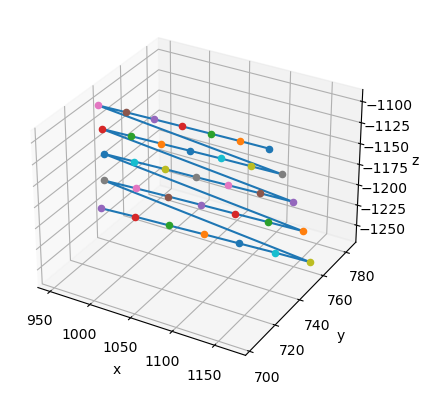

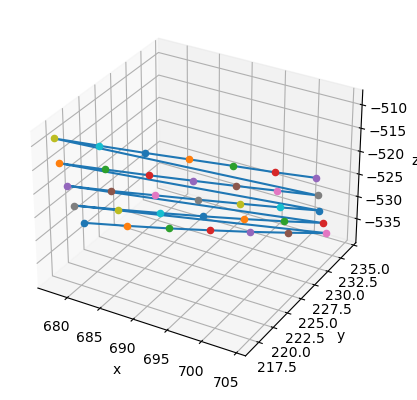

          X (1)       Y (1)        Z (1)  Tiefe C1 (1)  Tiefe C2 (1)       X (2)       Y (2)       Z (2)  Tiefe C1 (2)  Tiefe C2 (2)
0   1084.466743  783.090353 -1175.884073    981.346145    789.913648  680.265442  217.884125 -526.987732    107.984863    483.806160
1   1060.626971  774.432394 -1161.908656    956.926324    760.970093  684.513611  220.221237 -528.489807    107.664482    483.630821
2   1037.560862  765.956624 -1148.459714    933.549541    732.968456  688.541260  222.685257 -530.133545    107.662286    483.231774
3   1014.973954  757.674821 -1135.276787    910.911178    705.549142  692.401794  225.313034 -531.912170    107.945758    482.615802
4    993.163149  749.656407 -1122.562222    889.307426    679.073133  696.061646  228.075821 -533.863525    108.559051    481.760231
5    971.712653  741.724667 -1110.091003    868.325639    653.035783  699.515198  231.024323 -535.978760    109.468554    480.634456
6    950.552437  733.865738 -1097.813357    847.903831    627.351760 

In [104]:
def triangulate_and_evaluate(index_first, index_second, calibrator, reorder, out_dir, angle=None, add_points=None, verbose=False):
    importlib.reload(utils)
    importlib.reload(src.hz_triangulation)
    K_1, _ = calibrator.calculateProjection(index_first)
    K_2, _ = calibrator.calculateProjection(index_second)

    img1 = cv.imread('assets/calibration_new/img-%02d.jpg' % (index_first+1))
    img2 = cv.imread('assets/calibration_new/img-%02d.jpg' % (index_second+1))

    p1 = calibrator.imgpoints_as_int(index_first)
    if reorder[index_first]:
        p1 = np.flip(p1, 0)
    if add_points is not None:
        add = np.array(add_points[index_first])
        if (len(add) > 0):
            p1 = np.concatenate((p1, add))
            print(p1.shape)
            print(add.shape)
    p2 = calibrator.imgpoints_as_int(index_second)
    if reorder[index_second]:
        p2 = np.flip(p2, 0)
    if add_points is not None:
        add = np.array(add_points[index_second])
        if (len(add) > 0):
            p2 = np.concatenate((p2, add))
    if verbose:
        print(p1.shape, p2.shape, K_1.shape, K_2.shape)

    hz = HZTriangulation(img1, img2, p1, p2, K_1, K_2)
    if verbose:
        print('F:\n{hz.F}\n'.format(**locals()))
    hz.save_with_markers('%s/base-with-markers-%02i-%02i.jpg' %
                         (out_dir, index_first+1, index_second+1))

    points_hz = hz.triangulate()
    if verbose:
        print(points_hz)

    # triangulate points with opencv's method for comparison
    points_cv = hz.triangulateOpenCv()
    if verbose:
        print(points_cv)

    utils.plot_3d(points_hz, out_file='%s/3d-triangulated-hz-%02i-%02i.jpg' %
                  (out_dir, index_first+1, index_second+1), angle=angle)
    utils.plot_3d(points_cv, out_file='%s/3d-triangulated-cv-%02i-%02i.jpg' %
                  (out_dir, index_first+1, index_second+1), angle=angle)

    # Calculate Camera Center
    C = utils.camera_center(K_1)
    C_1 = utils.camera_center_inhomogen(K_1)
    C_2 = utils.camera_center_inhomogen(K_2)
    if verbose:
        print(C)
        print(K_1.dot(C))  # check if close to 0

    utils.evaluate_points((points_hz, points_cv), (C_1, C_2), calibrator.chessboardSize,
                          calibrator.size_of_chessboard_squares_mm, out_file='%s/evaluation-%02i-%02i' % (out_dir, index_first+1, index_second+1))
    print('done')


triangulate_and_evaluate(2, 3,
                         calibrator, imgpoints_reorder, 'assets/generated')

P for img-*.jpg, index: 0
[[   2877.190156365    -756.496302753    1508.054873312 1238588.146035681]
 [   -353.40757683     1077.305592559    2913.481833669  779150.189343512]
 [      0.071858484      -0.670938454       0.738023        703.826199649]]
P for img-*.jpg, index: 7
[[    902.235860349   -2958.976365587    1247.064021245 1810898.200627484]
 [   1233.638425081     685.996450143    2789.517118929  539268.521366998]
 [     -0.437397491      -0.414595631       0.79799367      874.16147787 ]]


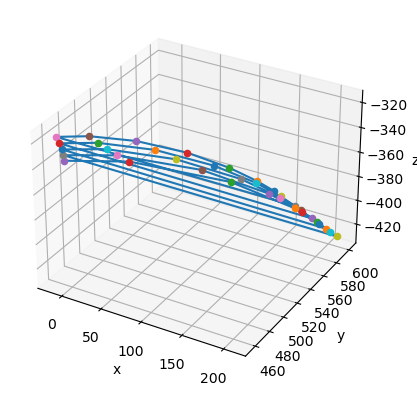

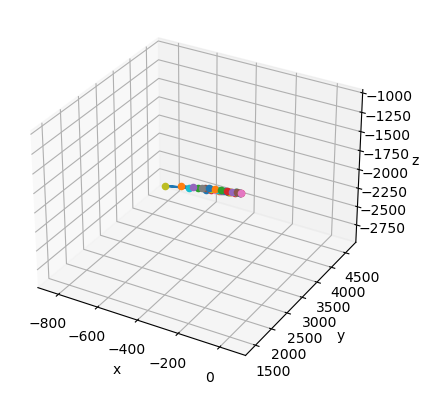

         X (1)       Y (1)       Z (1)  Tiefe C1 (1)  Tiefe C2 (1)       X (2)        Y (2)        Z (2)  Tiefe C1 (2)  Tiefe C2 (2)
0   145.179554  581.248301 -392.030999    212.404017    387.416334 -164.844406  1890.898926 -1373.176147   1639.519887   1722.216178
1   133.047681  570.171631 -380.465060    203.688275    401.933878 -122.665512  1817.359375 -1326.445679   1549.989435   1625.586069
2   113.293732  552.608886 -364.443890    191.678522    425.360741  -81.125778  1736.374023 -1276.262085   1453.294874   1521.674314
3    83.311149  527.516100 -345.383730    178.483032    460.271745  -41.208324  1652.099731 -1224.451660   1354.027220   1415.001626
4    46.663719  499.409944 -329.049548    169.933111    501.537994   -5.286910  1573.867920 -1176.113770   1262.786082   1316.294879
5    11.632099  475.927160 -320.222840    167.596388    538.948292   27.353909  1498.638306 -1130.036377   1176.295355   1222.304571
6   -14.584944  461.270891 -318.378231    167.549940    565.164709   

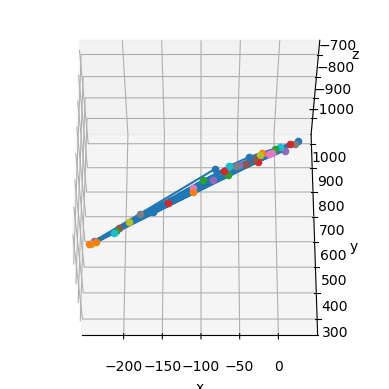

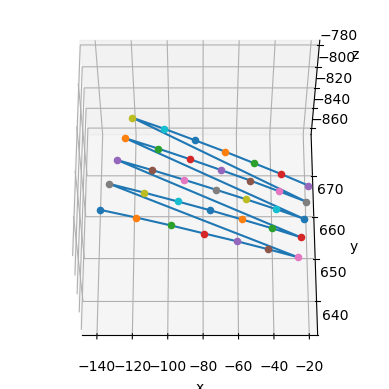

         X (1)       Y (1)        Z (1)  Tiefe C1 (1)  Tiefe C2 (1)       X (2)       Y (2)       Z (2)  Tiefe C1 (2)  Tiefe C2 (2)
0   -82.213553  743.148728  -892.034714    476.088463    238.392015 -140.013657  660.377014 -860.898499    424.444725    194.460890
1  -234.556793  288.932249  -668.241369    364.687510    382.863622 -118.399376  655.927185 -849.186462    407.855541    179.177491
2   -97.035170  681.358727  -868.654417    431.301698    186.820614  -98.267311  651.590698 -837.941772    392.827229    166.990202
3   -70.433506  749.940679  -908.216789    492.819232    242.983440  -79.385399  647.334106 -827.040527    379.115658    157.855543
4   -50.068307  797.682079  -937.682746    540.801747    290.083535  -61.612900  643.242920 -816.242798    366.434943    151.906643
5   -30.296569  841.213269  -965.512529    587.273348    336.698505  -45.115776  639.238098 -805.844360    354.969748    148.912043
6    -8.498879  887.631706  -995.460244    638.649574    389.012162  -29.639

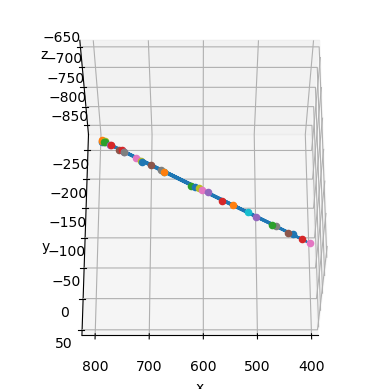

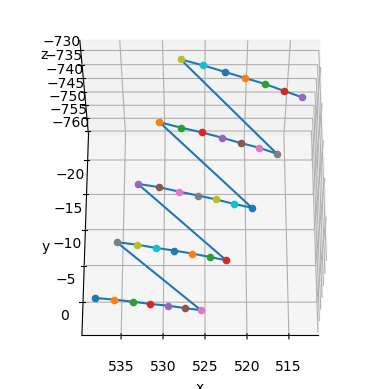

         X (1)       Y (1)       Z (1)  Tiefe C1 (1)  Tiefe C2 (1)       X (2)      Y (2)       Z (2)  Tiefe C1 (2)  Tiefe C2 (2)
0   714.968397 -188.171293 -808.157131    278.857295    244.781459  537.886292   2.663143 -750.874817    240.418555     70.971443
1   673.770393 -156.323496 -785.651604    258.898026    189.434122  535.668457   2.463211 -752.249451    239.345366     73.087296
2   623.495069 -117.994035 -758.679194    250.035559    124.256067  533.530762   2.305646 -753.651672    238.262887     75.228854
3   566.173166  -74.687650 -728.299887    262.190934     60.996526  531.465515   2.179467 -755.046875    237.202739     77.362215
4   506.815809  -30.135168 -697.124875    296.396536     66.438753  529.414551   1.998624 -756.387634    236.207235     79.449055
5   452.702833   10.337267 -668.828466    341.279735    127.761971  527.408813   1.879981 -757.842896    235.122266     81.638768
6   416.399443   37.555298 -649.732419    376.529019    174.204127  525.479736   1.756210 

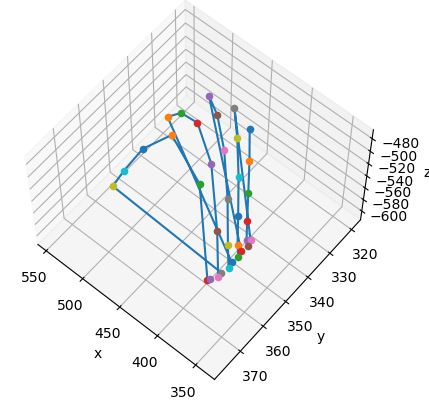

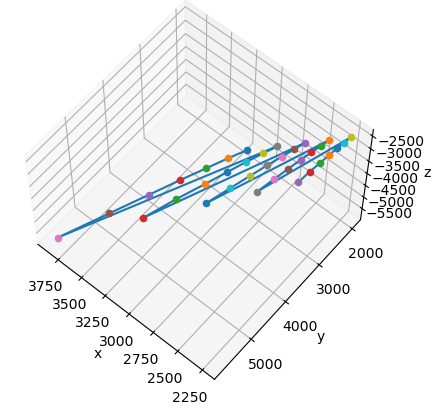

         X (1)       Y (1)       Z (1)  Tiefe C1 (1)  Tiefe C2 (1)        X (2)        Y (2)        Z (2)  Tiefe C1 (2)  Tiefe C2 (2)
0   441.420694  327.751724 -522.058868    215.278820    527.134871  2863.441406  3103.549805 -3178.940918   4374.333777   4565.302091
1   413.083402  337.583798 -509.034251    217.160158    553.165399  2960.933105  3355.655518 -3419.425049   4721.152497   4916.489858
2   385.722024  347.485457 -496.867678    223.117389    579.059363  3069.328369  3646.576416 -3700.450439   5124.044429   5323.597143
3   362.871583  355.826863 -487.038509    231.153662    600.999243  3205.094727  4009.187256 -4048.796387   5628.577075   5832.534311
4   348.140939  361.095058 -480.903017    237.754526    615.150438  3366.479736  4448.622559 -4474.018066   6244.078051   6452.292155
5   342.407483  362.612884 -478.673637    240.927519    620.237317  3574.879395  5016.898438 -5023.604004   7044.159650   7256.699283
6   344.815462  360.598054 -479.902546    240.492322    616.96

In [105]:
triangulate_and_evaluate(
    0, 7, calibrator, imgpoints_reorder, 'assets/generated')
triangulate_and_evaluate(
    0, 1, calibrator, imgpoints_reorder, 'assets/generated', angle=270)
triangulate_and_evaluate(
    4, 5, calibrator, imgpoints_reorder, 'assets/generated', angle=90)
triangulate_and_evaluate(
    7, 8, calibrator, imgpoints_reorder, 'assets/generated', angle=130)